# QA session on Lecture 4 

6th Feb. 2025

## Question from Toshiki-san

In notebook, we are exploring one point for each round, but can we consider exploring multiple points in one round?


## Answer

**Yes!** It is known as **Batch Bayesian Optimization**. In the setting, we query next points $\hat{x}_1, \hat{x}_q$ that maximizes acquisition function 
$$\hat{x}_1, \dots, \hat{x}_q = \arg\max \alpha(x_1,\dots, x_q)$$

Possible choice of aquisitions;

-  **q-EI**: Jointly choose $\hat{x}_1, \dots, \hat{x}_q$ by
$$ \hat{x}_1, \dots, \hat{x}_q = \arg\max_{x_1,\dots, x_q} \mathbb{E}[(\max_{i=1,\dots, q}  f(x_i) - y^*, 0)|\mathcal{D}]$$

- **Batch UCB**: Sequently choose $\hat{x_i}$ by
$$\hat{x_i} = \arg\max \mu(x|\mathcal{D}) + \beta \sigma(x|\mathcal{D}, {\color{red} \hat{x}_1, \dots, \hat{x}_{i-1}})$$

-  **Thompson Sampling**
$$ \hat{x_i} = \arg\max_x f_i(x) \quad f_i \sim \mathcal{GP}(\cdot|\mathcal{D})$$

## Question from Toshiki-san and Yusuke N.-san

How to sample initial points? Random sampling or any better choice?

## Answer

- The influence of initial points is minimal **in theory**, BO converges to the minimizer no matter what inital point to start. 

- However, the model might stuck to local optima in some case, hence it is advisable to try different initial points

- You can do both **random search** or **grid search**, and it is hard to tell which is better

## Question from Yusuke U.-san

There are two ways of encouraging exploration in EI. One is lifting threshold in EI by $\xi$ as
$$\mathbb{E}[\max(f(x) - y^* - \xi, 0)]$$
Another is use Augmented EI
$$\mathbb{E}[\max(f(x) - y^*, 0)]\left(1 - \frac{\sigma}{\sqrt{Var[f(x)] + \sigma^2}}\right) $$
Which is better?


## Answer

It is difficult to say one is better than another, but I think AEI is more widely used...?

## Question from Yusuke N.-san
Is Probaility of Improment used?
$$\mathbb{P}[f(x) > y^*|\mathcal{D}]$$
(cf: EI: $\mathbb{E}[\max(f(x) - y^*, 0)|\mathcal{D}]$)

I think people prefer EI over PI since EI can priortise where we can expect larger improvement, which is ignored in PI. 

In [29]:
# Silence some annyoing warnings:
import os
import warnings

warnings.simplefilter("ignore")
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

# Support for maths
import numpy as np
import tensorflow as tf

# Plotting tools
from matplotlib import pyplot as plt
# we use the following for plotting figures in jupyter
%matplotlib inline

# GPflow: Gaussian processes library
import gpflow
import trieste

In [7]:
def forrester_true(x):
    return (6.*x - 2)**2 * tf.sin(12.*x-4)

def forrester_sim(x):
    y = forrester_true(x)
    noise = tf.random.normal(y.shape, 0.0, 0.25, dtype=y.dtype)
    return y + noise

search_space = trieste.space.Box([0.0], [1.])

f_observer = trieste.objectives.utils.mk_observer(forrester_sim)

## Bug found by Yu-ichiro san

```
n = 10
X = np.random.default_rng(12345).random((n, 1))
data = f_observer(X)
search_space = trieste.space.Box([0.], [1.])

gpflow_m = trieste.models.gpflow.build_gpr(data, search_space)
m = trieste.models.gpflow.GaussianProcessRegression(gpflow_m)

optimiser = gpflow.optimizers.Scipy()
optimiser.minimize(gpflow_m.training_loss, gpflow_m.trainable_variables)
```

In [33]:
n = 10
X = np.random.default_rng(12345).random((n, 1))
data = f_observer(X)
search_space = search_space = trieste.space.Box([0.], [1.])

gpflow_m = trieste.models.gpflow.build_gpr(data, search_space)
m = trieste.models.gpflow.GaussianProcessRegression(gpflow_m)

optimiser = gpflow.optimizers.Scipy()
optimiser.minimize(gpflow_m.training_loss, gpflow_m.trainable_variables)



  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 26.768853626792666
        x: [-2.231e+00  2.017e+01  1.223e+00]
      nit: 20
      jac: [-1.252e-05  1.536e-06 -2.289e-06]
     nfev: 21
     njev: 21
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>

Plot the results
```
Xplot = np.linspace([0.0], [1.0], 200)
m_mean, _ = m.predict(Xplot)
gpflow_mean, _ = gpflow_m.predict_f(Xplot)
plt.plot(Xplot, m_mean, label="m.predict")
plt.plot(Xplot, gpflow_mean, label="gpflow_m.predict")
plt.legend()
```

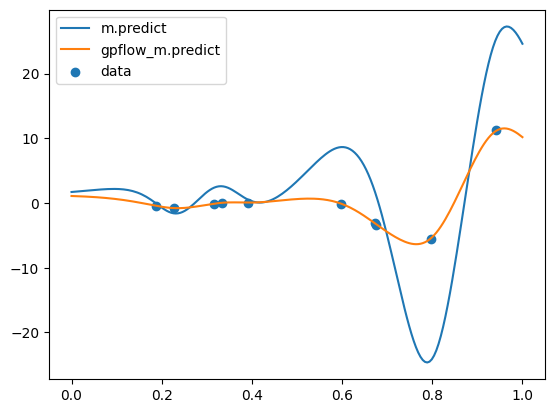

In [38]:
Xplot = np.linspace([0.0], [1.0], 200)
m_mean, _ = m.predict(Xplot)
gpflow_mean, _ = gpflow_m.predict_f(Xplot)
plt.plot(Xplot, m_mean, label="m.predict")
plt.plot(Xplot, gpflow_mean, label="gpflow_m.predict")
plt.scatter(data.query_points, data.observations, label="data")
plt.legend()

Because cache of trieste model is not updated...

### Fix 1

Update cache:
```
Xplot = np.linspace([0.0], [1.0], 200)
m.update_posterior_cache()
m_mean, _ = m.predict(Xplot)
gpflow_mean, _ = gpflow_m.predict_f(Xplot)
plt.plot(Xplot, m_mean, label="m.predict")
plt.plot(Xplot, gpflow_mean, label="gpflow_m.predict")
plt.scatter(data.query_points, data.observations, label="data")
plt.legend()
```

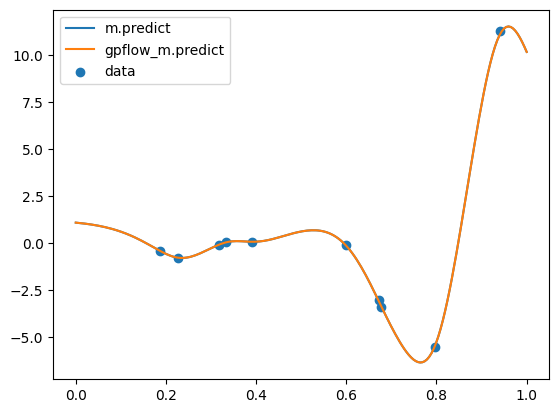

In [39]:
Xplot = np.linspace([0.0], [1.0], 200)
m.update_posterior_cache()
m_mean, _ = m.predict(Xplot)
gpflow_mean, _ = gpflow_m.predict_f(Xplot)
plt.plot(Xplot, m_mean, label="m.predict")
plt.plot(Xplot, gpflow_mean, label="gpflow_m.predict")
plt.scatter(data.query_points, data.observations, label="data")
plt.legend()

### Fix 2
Create trieste model after learning gpflow


```
n = 10
X = np.random.default_rng(12345).random((n, 1))
data = f_observer(X)
search_space = search_space = trieste.space.Box([0.], [1.])

gpflow_m = trieste.models.gpflow.build_gpr(data, search_space)
optimiser = gpflow.optimizers.Scipy()
optimiser.minimize(gpflow_m.training_loss, gpflow_m.trainable_variables)

m = trieste.models.gpflow.GaussianProcessRegression(gpflow_m)
```